In [1]:
from __future__ import division
import numpy as np
import math
import yaml
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm_notebook
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
class NetworkP:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1):
        """
        Initialises the Network object
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition

        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if state1<self.n1+1:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)
            
    def get_time_step_upper_bound(self):
        return 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        

    def discretise_transition_matrix(self, time_step=None):
        """
        Disctetises the transition matrix
        """
        if time_step is None:
            self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        else:
            self.time_step = time_step
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))

        
class NetworkPv:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1):
        """
        Initialises the Network object
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition

        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if state1<self.n1:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)
            
    def get_time_step_upper_bound(self):
        return 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        

    def discretise_transition_matrix(self, time_step=None):
        """
        Disctetises the transition matrix
        """
        if time_step is None:
            self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        else:
            self.time_step = time_step
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))


        
        
def find_time_step(schedule_lengths, upper_bound):
    """
    schedule_lengths: tuple of the form (length1, length2)
    upper_bound: the upper bound of the time step size
    """    
    d = math.gcd(*schedule_lengths)
    delta = d / math.ceil(d/upper_bound)
    discrete_schedule_lengths = [s / delta for s in schedule_lengths]
    return delta, discrete_schedule_lengths

In [3]:
def obtain_transition_matrices(n, mu, r11, L, schedule_lengths):
    N, Nv = NetworkP(n, mu, r11, L), NetworkPv(n, 0, r11, L)
    upper_bound = N.get_time_step_upper_bound()
    delta, discrete_schedule_lengths = find_time_step(schedule_lengths, upper_bound)
    
    N.discretise_transition_matrix(time_step=delta)
    P = N.discrete_transition_matrix
    
    Nv.discretise_transition_matrix(delta)
    Pv = Nv.discrete_transition_matrix
    

    return P, Pv, discrete_schedule_lengths, delta

In [4]:
def obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .9999):
    P, Pv, discrete_schedule_lengths, delta = obtain_transition_matrices(n, mu, r11, L, schedule_lengths)
    
    step_counts = [0, 1]
    approx_cdf = [0, P[0, -1]]
    approx_pdf = [0, P[0, -1]]
    transition_matrix = P
    step = 1
    
    while approx_cdf[-1] < stopping_probability:
        step += 1
        if step % sum(discrete_schedule_lengths) < discrete_schedule_lengths[0]:
            transition_matrix = np.matmul(transition_matrix, P)
        else:
            transition_matrix = np.matmul(transition_matrix, Pv)
        step_counts.append(step)
        absorption_prob = transition_matrix[0, -1]
        approx_cdf.append(absorption_prob)
        approx_pdf.append(approx_cdf[-1] - approx_cdf[-2])
    
    pdf = [p / sum(approx_pdf) for p in approx_pdf]
    cdf = np.cumsum(pdf)
    time_steps = [s * delta for s in step_counts]
    return time_steps, pdf, cdf

In [5]:
def mean_time_till_deadlock(n, mu, r11, L, schedule_lengths, stopping_probability = .999):
    time_steps, pdf, cdf = obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .9999)
    return sum([step * prob for step, prob in zip(time_steps, pdf)])

In [6]:
n, mu, r11, L = 6, 4, .2, 2
s = 10
sv = 5

In [12]:
variables = [0.2, 0.4, 0.6, 0.8, 1.0]

time_steps_dict = {}
pdf_dict = {}
cdf_dict = {}

for var in variables:
    time_steps_dict[var], pdf_dict[var], cdf_dict[var] = obtain_probability_distributions(n, mu, var, mu, (s, sv), stopping_probability = .9999)

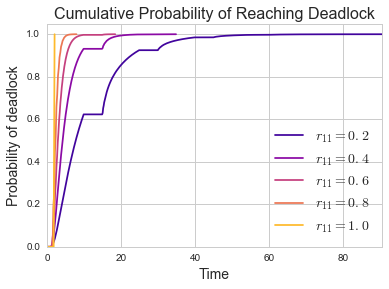

In [13]:
plt.figure()
colours = [cm.plasma(x) for x in np.linspace(0.1, 0.85, len(variables))]

for i in range(len(variables)):
    plt.plot(time_steps_dict[variables[i]], cdf_dict[variables[i]], c=colours[i], label=r"$r_{11} = " + str(variables[i]) + "$")

plt.xlabel("Time", fontsize=14)
plt.xlim(time_steps_dict[0.2][0], time_steps_dict[0.2][-1])
# plt.xlim(0, 520)
plt.ylabel("Probability of deadlock", fontsize="14")
plt.ylim(0, 1.05)
plt.title("Cumulative Probability of Reaching Deadlock", fontsize=16)
plt.legend(loc=0, fontsize=14)
# plt.show()
plt.savefig("tex/img/cdf_vary_r11.pdf")

In [25]:
n, mu, r11, L = 6, 4, .2, 2
s = 10
sv = 5

variables = np.linspace(0.05, 1.0, 20)
# variables = [i for i in range(0, 13)]
print(variables)
deadlock_times = []
for r11 in tqdm_notebook(variables):
    deadlock_times.append(mean_time_till_deadlock(n, mu, r11, L, (s, sv), stopping_probability = .999))

[ 0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6
  0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]



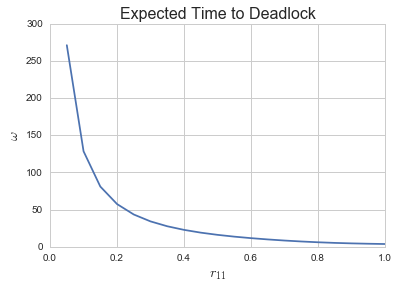

In [26]:
plt.figure()
plt.plot(variables, deadlock_times)

plt.xlabel(r"$r_{11}$", fontsize=14)
plt.ylabel(r"$\omega$", fontsize="14")
plt.title("Expected Time to Deadlock", fontsize=16)
# plt.show()
plt.savefig("tex/img/ttd_vary_r11.pdf")

In [27]:
L = 2.0
mu = 4.0
r11 = 0.2
s = 10
sv = 5
n = 6

In [28]:
time_steps, pdf, cdf = obtain_probability_distributions(n, mu, r11, L, (s, sv), stopping_probability = .999)

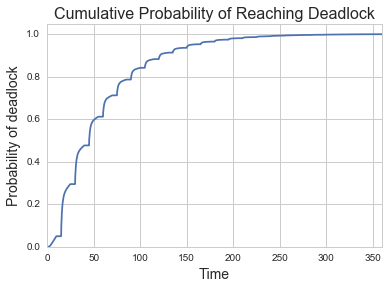

In [29]:
plt.figure()
plt.plot(time_steps, cdf)
plt.xlabel("Time", fontsize=14)
plt.xlim(time_steps[0], time_steps[-1])
plt.ylabel("Probability of deadlock", fontsize="14")
plt.ylim(0, 1.05)
plt.title("Cumulative Probability of Reaching Deadlock", fontsize=16)
plt.savefig("tex/img/cdf_initial.pdf")

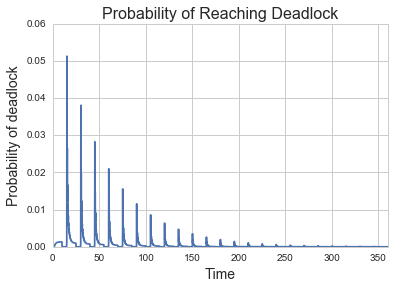

In [30]:
plt.figure()
plt.plot(time_steps, pdf)
plt.xlabel("Time", fontsize=14)
plt.xlim(time_steps[0], time_steps[-1])
plt.ylabel("Probability of deadlock", fontsize=14)
plt.title("Probability of Reaching Deadlock", fontsize=16)
plt.savefig("tex/img/pdf_initial.pdf")

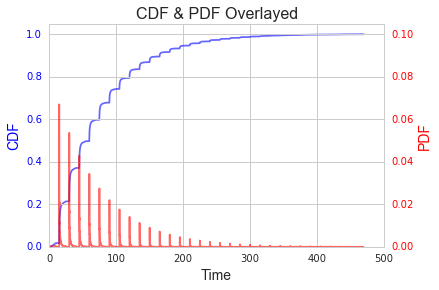

In [109]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(time_steps, cdf, c='b', alpha=0.6)
ax1.set_xlabel('Time', fontsize=14)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('CDF', color='b', fontsize=14)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylim(0, 1.05)

ax2.plot(time_steps, pdf, c='r', alpha=0.6)
ax2.set_ylabel('PDF', color='r', fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.set_ylim(0, 0.105)

plt.title("CDF & PDF Overlayed", fontsize=16)
plt.savefig("tex/img/cdfpdf_initial.pdf")

In [6]:
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    n, mu, r11, L = 6, i, .1, 2
    s = 10
    sv = 5
    d = mean_time_till_deadlock(n, mu, r11, L, (s, sv), stopping_probability = .999)
    dinv = mean_time_till_deadlock(n, 1.0/mu, r11, L, (s, sv), stopping_probability = .999)
    print(d, dinv)

30.6433136248 30.6433136248
36.4559411871 41.4559431143
54.2854966765 55.3383135762
74.9365651711 69.8434715977
91.9233371025 84.5082218274
104.384723123 99.3183363973
113.465610633 114.181928357
120.352665035 129.077652525
125.804598043 143.994276499
130.152793472 158.925293006


In [31]:
def loop_through(startmu, step, n1, r11, L1, s, sv):
    deadlock_list = [float('Inf')]
    prevmu = 0.0
    i = startmu
    go = True
    while go:
        mu1 = i
        deadlock_list.append(mean_time_till_deadlock(n, mu, r11, L, (s, sv), stopping_probability = .999))
        if deadlock_list[-1] > deadlock_list[-2]:
            go = False
            actualmu = prevmu
        else:
            prevmu = i
            i += step
    return actualmu

def find_threshold_to_5dc(start, n1, r11, L1, s, sv):
    s1 = loop_through(start, 0.1, n1, r11, L1, s, sv)
    print('s1 done')
    s2 = loop_through(s1, 0.01, n1, r11, L1, s, sv)
    print('s2, done')
    s3 = loop_through(s2, 0.001, n1, r11, L1, s, sv)
    print('s3 done')
    s4 = loop_through(s3, 0.0001, n1, r11, L1, s, sv)
    # s5 = loop_through(s4, 0.00001, n1, r11, L1, s, sv)
    # s6 = loop_through(s5, 0.000001, n1, r11, L1, s, sv)
    return s6

In [ ]:
n, r11, L = 6, .1, 2
s = 10
sv = 5
find_threshold_to_5dc(0.8, n, r11, L, s, sv)